Notebook to analyse the relation of the amount of SBP adoption in each municipality in each year with the various features

## Content
* Data ingestion
* Data first exploration
* Features analysis
    * Variance analysis
    * Correlation - Spearman rho and correlation matrices
        * All years
        * Restricted to PCF years (and comparison with all years)
        * Low correlations
        * Squared cumulative adoption
        * Census features combinations
* Multicollinearity analysis (VIF)
    * With census features combined and not
* Outliers removal

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
path_to_final_dataset = "Municipalities final dataset for analysis.csv"

In [4]:
# How to display floats
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=6)

# Data ingestion

In [5]:
dataset_original = pd.read_csv(path_to_final_dataset, index_col=['Municipality', 'Year'])

In [6]:
dataset_original.shape

(1241, 45)

In [7]:
dataset = dataset_original.reset_index(drop=True)

In [8]:
dataset.head(2)

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
0,0.013,0.000,0.000,0.315,0.117,0.766,6.660,0.896,4.420,0.164,...,0.938,685.085,289.653,68.951,11.578,15.374,1.327,6.903,5.697,0.000
1,0.007,0.013,0.001,0.298,0.110,0.743,6.820,0.907,4.540,0.166,...,0.938,685.085,289.653,68.951,11.578,15.374,1.327,6.903,5.697,0.000


In [9]:
dataset.columns

Index(['adoption_in_year', 'tot_cumul_adoption_pr_y_munic',
       'tot_cumul_adoption_pr_y_port', 'pastures_area_var',
       'pastures_area_munic', 'pastures_area_mean', 'agric_area_mean',
       'agric_area_owned', 'tract_100ha', 'lu_cattle', 'lu_per_agric_area',
       'farmers_female', 'farmers_over65', 'educ_none', 'educ_second_super',
       'agric_time_full', 'inc_excl_agric', 'inc_mainly_ext',
       'work_unit_100ha', 'av_d_mean_t_pr_y_munic',
       'days_mean_t_over_20_pr_y_munic', 'days_mean_t_over_25_pr_y_munic',
       'av_d_max_t_pr_y_munic', 'days_max_t_over_30_pr_y_munic',
       'av_d_min_t_pr_y_munic', 'days_min_t_under_0_pr_y_munic',
       'av_prec_sum_pr_y_munic', 'days_no_prec_pr_y_munic',
       'cons_days_no_prec_pr_y_munic', 'av_d_mean_t_average_munic',
       'days_mean_t_over_20_average_munic',
       'days_mean_t_over_25_average_munic', 'av_d_max_t_average_munic',
       'days_max_t_over_30_average_munic', 'av_d_min_t_average_munic',
       'days_min_t_und

## Organise features by categorical/numerical and by topic

In [10]:
label = ['adoption_in_year']

In [11]:
features_list = [col for col in dataset.columns if col != 'adoption_in_year']
features = pd.DataFrame(index=dataset.columns, columns=['num/cat', 'topic'])

In [12]:
adoption_features = [feat for feat in features.index if 'adoption' in feat and feat not in label]
features.loc[adoption_features, :] = ['num', 'SBP_adoption']

In [13]:
climate_features = [feat for feat in features.index if '_t_' in feat or '_prec_' in feat]
features.loc[climate_features, :] = ['num', 'climate']

In [14]:
soil_features = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features.loc[soil_features, :] = ['num', 'soil']

In [15]:
economic_features = ['sbp_payment']
features.loc[economic_features, :] = ['num', 'economic']

In [16]:
features_not_census = adoption_features + climate_features + soil_features + economic_features 
census_features = [feat for feat in features_list if feat not in features_not_census]
features.loc[census_features, :] = ['num', 'census']

# First exploration

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241 entries, 0 to 1240
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   adoption_in_year                   1241 non-null   float64
 1   tot_cumul_adoption_pr_y_munic      1241 non-null   float64
 2   tot_cumul_adoption_pr_y_port       1241 non-null   float64
 3   pastures_area_var                  1241 non-null   float64
 4   pastures_area_munic                1241 non-null   float64
 5   pastures_area_mean                 1241 non-null   float64
 6   agric_area_mean                    1241 non-null   float64
 7   agric_area_owned                   1241 non-null   float64
 8   tract_100ha                        1241 non-null   float64
 9   lu_cattle                          1241 non-null   float64
 10  lu_per_agric_area                  1241 non-null   float64
 11  farmers_female                     1241 non-null   float

In [18]:
dataset.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,...,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000,1241.000
mean,0.006,0.034,0.026,0.907,0.439,23.078,46.187,0.715,3.099,0.475,...,5.553,619.891,292.467,70.542,25.800,12.127,1.476,14.126,6.129,32.477
std,0.011,0.051,0.022,0.513,0.227,23.673,38.592,0.107,3.097,0.208,...,8.001,77.607,5.508,7.539,22.049,1.215,0.236,5.639,0.364,58.749
min,0.000,0.000,0.000,0.201,0.021,0.090,4.280,0.409,0.300,0.047,...,0.023,482.106,281.215,54.842,2.612,10.109,1.004,6.606,5.321,0.000
25%,0.001,0.005,0.006,0.736,0.254,3.868,11.900,0.651,0.950,0.314,...,0.167,559.929,287.958,65.271,8.750,11.198,1.343,10.259,5.896,0.000
50%,0.002,0.018,0.022,0.945,0.434,15.611,41.280,0.718,1.520,0.493,...,2.500,602.690,294.468,72.021,19.092,11.879,1.483,12.600,6.081,0.000
75%,0.007,0.040,0.043,1.007,0.622,34.821,66.540,0.781,4.820,0.639,...,7.056,677.158,296.449,76.799,35.113,12.848,1.626,17.468,6.433,0.000
max,0.197,0.526,0.068,7.413,0.921,135.392,173.500,0.965,17.400,0.958,...,33.767,796.201,301.375,83.458,111.861,15.566,2.188,29.620,7.009,153.260


array([[<AxesSubplot:title={'center':'adoption_in_year'}>]], dtype=object)

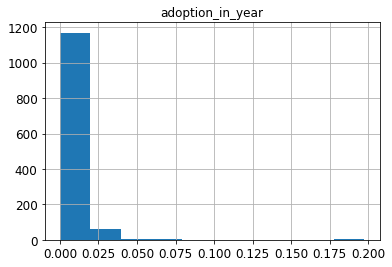

In [19]:
# Target variable distribution
dataset[label].hist()

In [20]:
adoption_features = features.loc[features['topic'] == 'SBP_adoption'].index.tolist()
#dataset[adoption_features].hist(figsize=(20, 20))

In [21]:
census_features = features.loc[(features['topic'] == 'census')].index.tolist()
#dataset[census_features].hist(figsize=(20, 20))

In [22]:
climate_features = features.loc[features['topic'] == 'climate'].index.tolist()
#dataset[climate_features].hist(figsize=(20, 20))

In [23]:
soil_features = features.loc[features['topic'] == 'soil'].index.tolist()
#dataset[soil_features].hist(figsize=(15, 8))

In [24]:
features_num = features.loc[features['num/cat'] == 'num'].index.tolist()

# Features analysis

## Correlation analysis with label - Spearman rho and matrices

#### Test for normality distribution the datasets' columns

In [25]:
from scipy.stats import kstest

results_ks = pd.DataFrame(index=features_num, columns=['statistic', 'p-value'])
for (columnName, columnData) in dataset.iteritems():
    stat, p = kstest(columnData, 'norm')
    results_ks.loc[columnName] = [stat, p]

In [26]:
(results_ks['p-value'] > 0.05).any()

False

### All years

In [27]:
from scipy.stats import spearmanr

def get_spearmanr_results(features):
    results = pd.DataFrame(index=features, columns=['spearman r'])

    for (columnName, columnData) in dataset[features].iteritems():
        coef, p = spearmanr(columnData, dataset['adoption_in_year'])
        results.loc[columnName] = coef
    return results

In [28]:
spearman_results = get_spearmanr_results(features_num)

In [29]:
spearman_results.loc[adoption_features, :].sort_values('spearman r', ascending=False)

,spearman r
tot_cumul_adoption_pr_y_munic,0.456
tot_cumul_adoption_pr_y_port,0.250


In [30]:
spearman_results.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r
pastures_area_var,0.199
farmers_female,0.152
educ_second_super,0.107
tract_100ha,0.098
lu_per_agric_area,0.097
pastures_area_munic,0.062
work_unit_100ha,0.052
inc_mainly_ext,0.024
pastures_area_mean,0.018
farmers_over65,0.011


In [31]:
spearman_results.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r
days_mean_t_over_20_pr_y_munic,0.118
av_prec_sum_average_munic,0.118
av_d_min_t_average_munic,0.113
av_d_min_t_pr_y_munic,0.107
days_no_prec_pr_y_munic,0.095
av_d_max_t_pr_y_munic,0.045
days_max_t_over_30_pr_y_munic,0.045
days_mean_t_over_25_pr_y_munic,0.029
av_d_mean_t_pr_y_munic,0.016
days_min_t_under_0_pr_y_munic,0.012


In [32]:
spearman_results.loc[soil_features, :].sort_values('spearman r', ascending=False)

,spearman r
CN_mean_munic,0.117
CaCO3_mean_munic,0.116
pH_mean_munic,0.068
P_mean_munic,0.033
N_mean_munic,-0.101


In [33]:
economic_features = features.loc[(features['topic'] == 'economic')].index.tolist()
spearman_results.loc[economic_features, :].sort_values('spearman r', ascending=False)

,spearman r
sbp_payment,0.070


#### Corrrelation matrix to spot also relation among the features

In [34]:
corr_matrix_sp = dataset.corr(method='spearman').round(decimals=2)

In [35]:
def plot_correlation_heatmap(matrix, size=(20, 20)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=range(len(matrix.index)), ticklabels=matrix.index)
    plt.xticks(rotation=90)
    ax.yaxis.set(ticks=range(len(matrix.columns)), ticklabels=matrix.columns)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            ax.text(j, i, matrix.iloc[i, j], ha='center', va='center',
                    color='r')
    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()

In [36]:
climate_features_average = [feat for feat in climate_features if 'average' in feat]

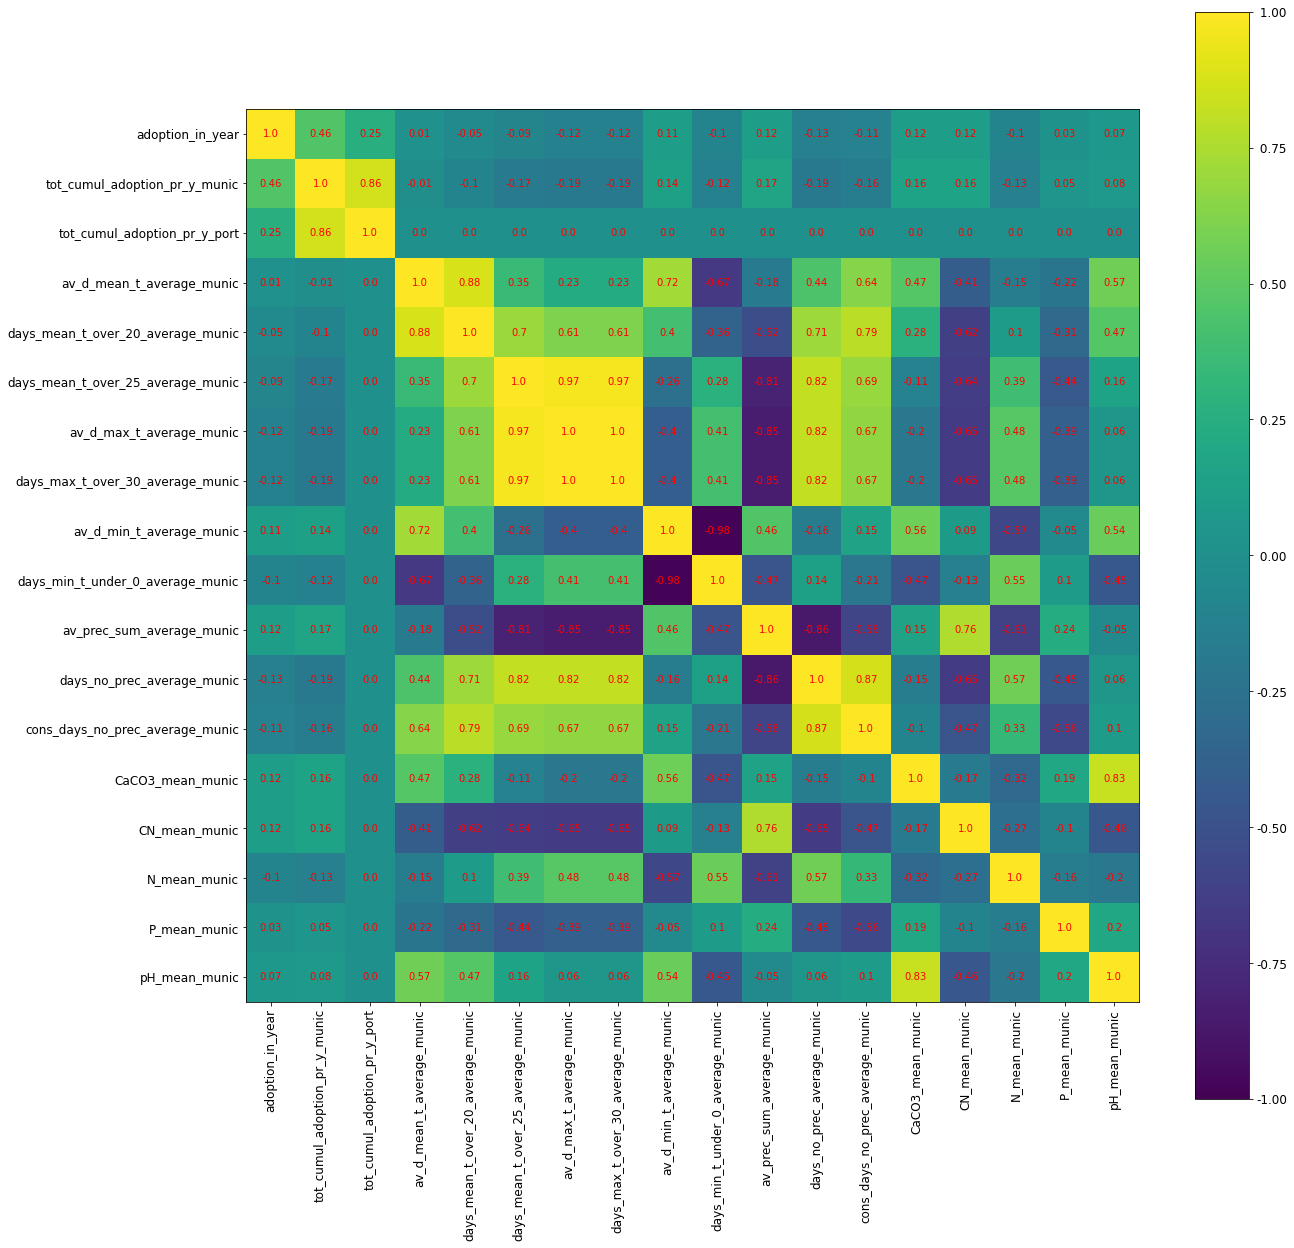

In [37]:
features_to_show = label + adoption_features + climate_features_average + soil_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on census features

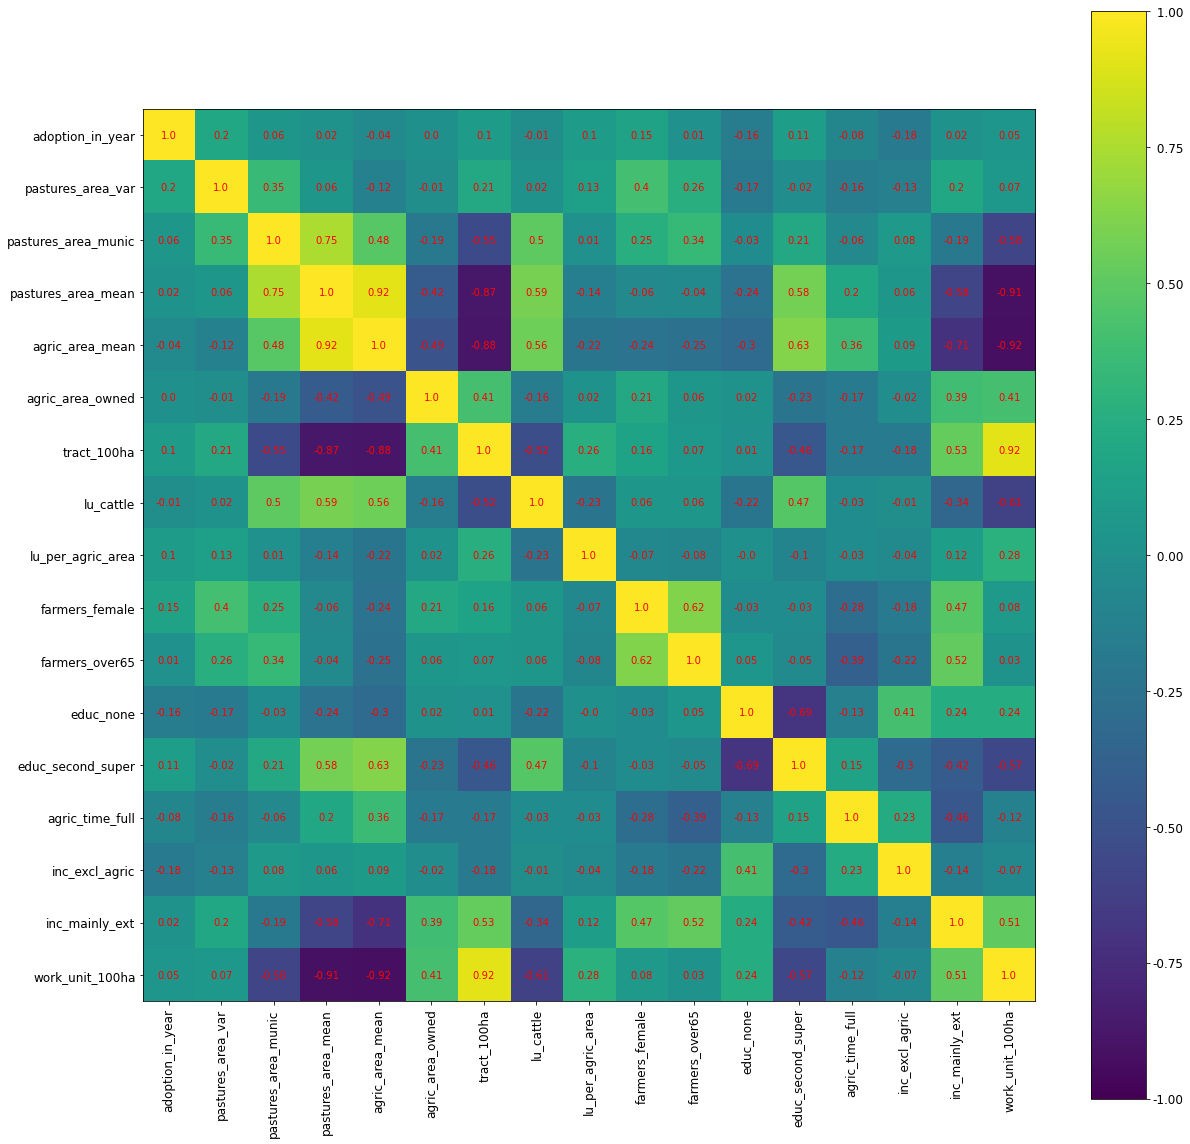

In [38]:
features_to_show = label + census_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

Environmental features

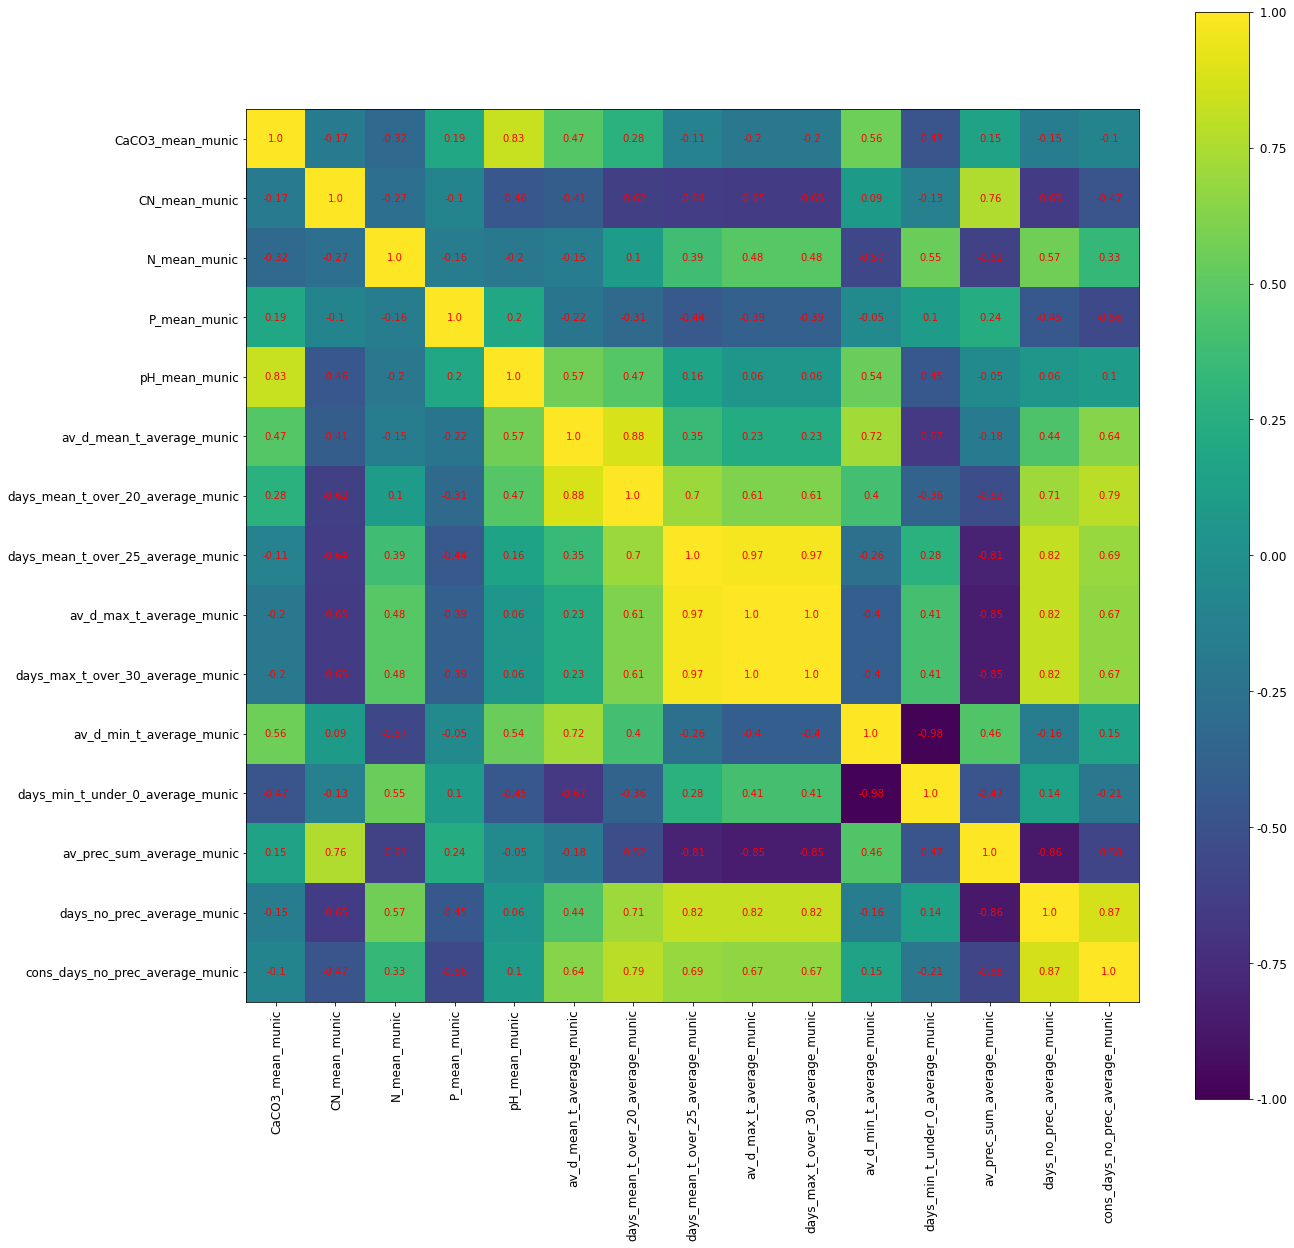

In [39]:
features_to_show = soil_features + climate_features_average
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

### Restricted to PCF years (and comparison with all years)¶

Analysis to check correlations only during the years of the PCF projects, since these are the years for which we have reliable labels.

In [40]:
dataset_PCF = dataset_original.loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [41]:
dataset_PCF = dataset_PCF.reset_index(drop=True)

In [42]:
len(dataset_PCF)

292

In [43]:
dataset_PCF.describe()

,adoption_in_year,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_munic,pastures_area_mean,agric_area_mean,agric_area_owned,tract_100ha,lu_cattle,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,...,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000,292.000
mean,0.009,0.075,0.058,1.012,0.526,30.472,50.344,0.700,3.385,0.548,...,5.553,619.891,292.467,70.542,25.800,12.127,1.476,14.126,6.129,138.028
std,0.020,0.071,0.008,0.060,0.234,29.370,40.490,0.119,3.468,0.219,...,8.012,77.708,5.515,7.549,22.077,1.217,0.236,5.647,0.365,9.404
min,0.000,0.018,0.047,0.800,0.061,0.424,5.500,0.411,0.300,0.047,...,0.023,482.106,281.215,54.842,2.612,10.109,1.004,6.606,5.321,128.790
25%,0.000,0.031,0.052,0.992,0.339,6.030,13.667,0.617,0.998,0.399,...,0.167,559.929,287.958,65.271,8.750,11.198,1.343,10.259,5.896,131.272
50%,0.005,0.048,0.058,1.000,0.561,23.367,43.990,0.713,1.700,0.584,...,2.500,602.690,294.468,72.021,19.092,11.879,1.483,12.600,6.081,135.030
75%,0.012,0.080,0.064,1.031,0.710,46.399,69.100,0.772,4.960,0.723,...,7.056,677.158,296.449,76.799,35.113,12.848,1.626,17.468,6.433,141.785
max,0.197,0.526,0.068,1.641,0.911,135.392,157.030,0.961,17.400,0.958,...,33.767,796.201,301.375,83.458,111.861,15.566,2.188,29.620,7.009,153.260


In [44]:
from scipy.stats import spearmanr

spearman_results_PCF = pd.DataFrame(index=features_num, columns=['spearman r only PCF'])

for (columnName, columnData) in dataset_PCF[features_num].iteritems():
    coef, p = spearmanr(columnData, dataset_PCF['adoption_in_year'])
    spearman_results_PCF.loc[columnName] = coef

In [45]:
# Merge with spearman rho results with all to compare
spearman_results_both = pd.concat([spearman_results_PCF, spearman_results], axis=1)

In [46]:
spearman_results_both.loc[adoption_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
tot_cumul_adoption_pr_y_munic,0.076,0.456
tot_cumul_adoption_pr_y_port,0.002,0.250


In [47]:
spearman_results_both.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
pastures_area_var,0.039,0.199
farmers_female,-0.023,0.152
educ_second_super,0.402,0.107
tract_100ha,-0.307,0.098
lu_per_agric_area,-0.069,0.097
pastures_area_munic,0.160,0.062
work_unit_100ha,-0.251,0.052
inc_mainly_ext,-0.325,0.024
pastures_area_mean,0.313,0.018
farmers_over65,-0.187,0.011


In [48]:
spearman_results_both.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
days_mean_t_over_20_pr_y_munic,0.185,0.118
av_prec_sum_average_munic,-0.176,0.118
av_d_min_t_average_munic,-0.042,0.113
av_d_min_t_pr_y_munic,-0.029,0.107
days_no_prec_pr_y_munic,0.065,0.095
av_d_max_t_pr_y_munic,0.304,0.045
days_max_t_over_30_pr_y_munic,0.304,0.045
days_mean_t_over_25_pr_y_munic,0.256,0.029
av_d_mean_t_pr_y_munic,0.106,0.016
days_min_t_under_0_pr_y_munic,0.059,0.012


In [49]:
spearman_results_both.loc[soil_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pH_mean_munic,0.028,0.068
N_mean_munic,-0.009,-0.101
P_mean_munic,-0.055,0.033
CaCO3_mean_munic,-0.111,0.116
CN_mean_munic,-0.174,0.117


In [50]:
spearman_results_both.loc[economic_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
sbp_payment,0.014,0.070


# Multicollinearity analysis (VIF)

**NOTE:** 
* dataset refers to the dataset with all features
* dataset_attr_red refers to the dataset with attributes reduced based on correlation coefficients

Based on dataset including all years (unless not clear)

In [51]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [52]:
def calculate_vif(dataset):
    features = "+".join([feat for feat in dataset.columns if feat != "adoption_in_year"])
    y, X = dmatrices('adoption_in_year ~' + features, dataset, return_type='dataframe')
    with pd.option_context('mode.use_inf_as_null', True):
        X = X.dropna()

    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.set_index("features", inplace=True)
    return vif

In [53]:
vif = calculate_vif(dataset)

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [54]:
vif.sort_values('VIF', ascending=False).head(10)

,VIF
features,
av_d_max_t_pr_y_munic,inf
days_max_t_over_30_pr_y_munic,inf
days_max_t_over_30_average_munic,inf
av_d_max_t_average_munic,inf
Intercept,990384.812
av_d_mean_t_average_munic,1373.282
days_mean_t_over_20_average_munic,643.827
av_d_min_t_average_munic,535.389
days_min_t_under_0_average_munic,248.571


## Custom transformers to reduce features and multicollinearity

Create a different transformer for each topic of features, to not have any VIF above 10

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

In [56]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

In [57]:
corr_matrix = dataset.corr(method='spearman').round(decimals=2)

In [58]:
sp_r_both = get_spearman_both('all', dataset, dataset_PCF)

### Census features

In [59]:
census_features_indic = pd.concat(
    [spearman_results_both.loc[census_features, :], vif.loc[census_features]], axis=1, join='inner'
)

In [60]:
census_features_indic.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r,VIF
pastures_area_var,0.039,0.199,1.713
farmers_female,-0.023,0.152,4.090
educ_second_super,0.402,0.107,5.741
tract_100ha,-0.307,0.098,13.835
lu_per_agric_area,-0.069,0.097,2.753
pastures_area_munic,0.160,0.062,11.326
work_unit_100ha,-0.251,0.052,13.000
inc_mainly_ext,-0.325,0.024,8.758
pastures_area_mean,0.313,0.018,14.342
farmers_over65,-0.187,0.011,6.428


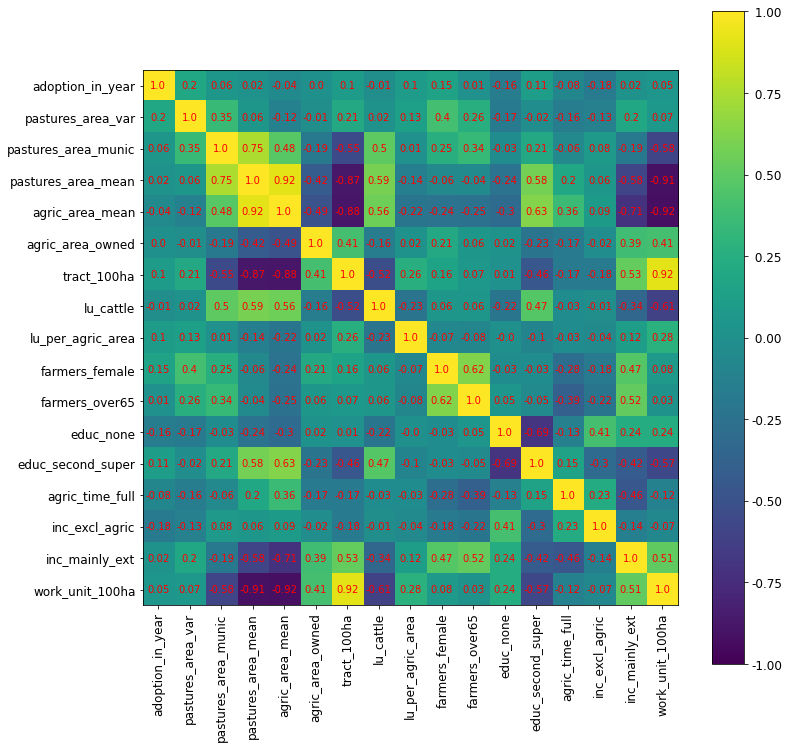

In [61]:
plot_correlation_heatmap(corr_matrix.loc[label + census_features, label + census_features], size=(12, 12))

In [62]:
class TransformCensusFeatures(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Features removed (thus not added): pastures_area_munic, agric_area_mean, farmers_female, inc_excl_agric,
        # tract_100ha
        
        feats_to_keep = ['pastures_area_var', 'pastures_area_mean', 'educ_second_super', 'farmers_over65', 
                        'inc_mainly_ext', 'educ_none', 'work_unit_100ha', 'agric_area_owned', 'lu_per_agric_area']
        XX = X[feats_to_keep]    

        return XX

### Adoption features

In [63]:
adoption_features

['tot_cumul_adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_port']

In [64]:
vif.loc[adoption_features]

,VIF
features,
tot_cumul_adoption_pr_y_munic,1.866
tot_cumul_adoption_pr_y_port,10.839


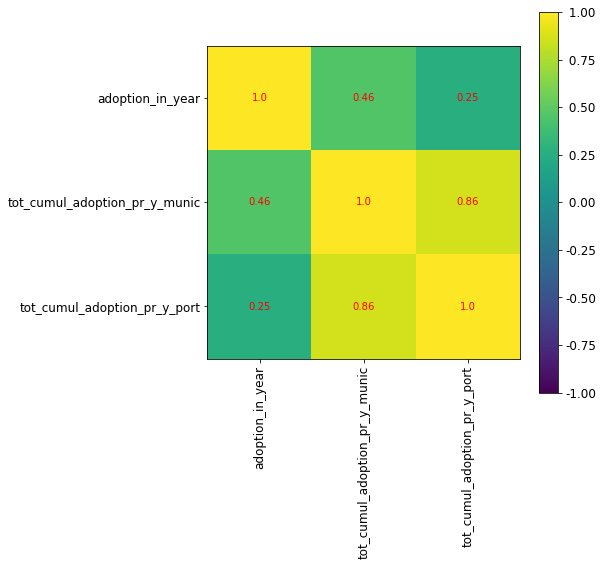

In [65]:
plot_correlation_heatmap(corr_matrix.loc[label + adoption_features, label + adoption_features], size=(7, 7))

In [66]:
sp_r_both.loc[adoption_features].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
tot_cumul_adoption_pr_y_munic,0.076,0.456
tot_cumul_adoption_pr_y_port,0.002,0.250


In [67]:
class TransformAdoptionFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feats_to_keep = ["tot_cumul_adoption_pr_y_munic", "tot_cumul_adoption_pr_y_port"]
        
        return X[feats_to_keep]

### Soil and climate features

In [68]:
env_features = soil_features + climate_features

In [69]:
prec_features = [feat for feat in climate_features if '_prec' in feat]

In [70]:
sp_r_both.loc[prec_features].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
av_prec_sum_average_munic,-0.176,0.118
days_no_prec_pr_y_munic,0.065,0.095
cons_days_no_prec_pr_y_munic,0.199,-0.090
av_prec_sum_pr_y_munic,-0.067,-0.091
cons_days_no_prec_average_munic,0.192,-0.112
days_no_prec_average_munic,0.197,-0.132


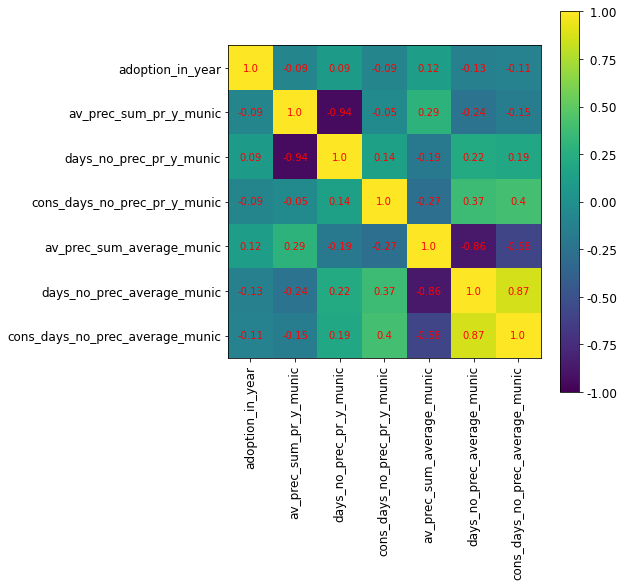

In [71]:
plot_correlation_heatmap(corr_matrix.loc[label + prec_features, label + prec_features], size=(7, 7))

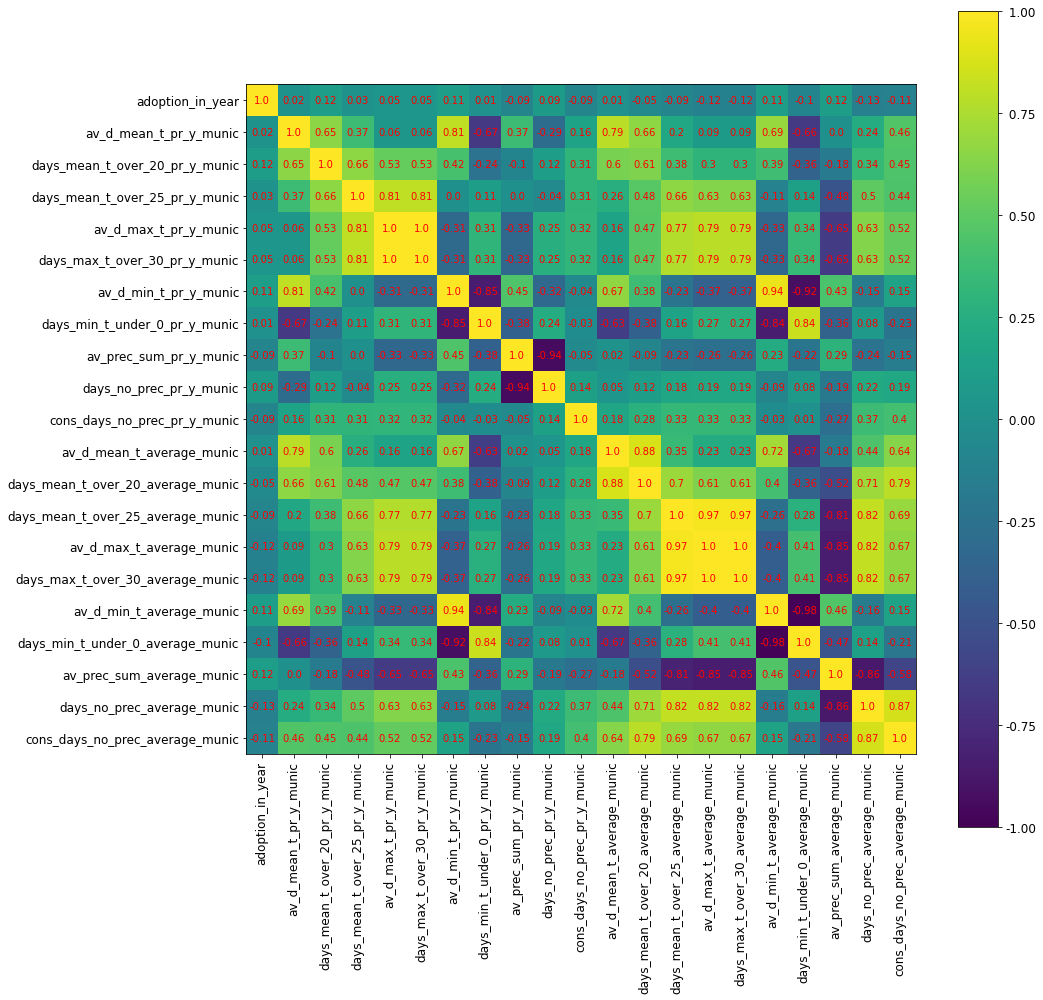

In [72]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features, label + climate_features], size=(15, 15))

In [73]:
feats_mean_t = [feat for feat in climate_features if 'av_d_mean_t' in feat]
feats_max_t = [feat for feat in climate_features if 'av_d_max_t' in feat]
feats_prec = [feat for feat in climate_features if 'cons_days_no_prec' in feat or 'av_prec_sum' in feat]
climate_features_kept = feats_mean_t + feats_max_t + feats_prec

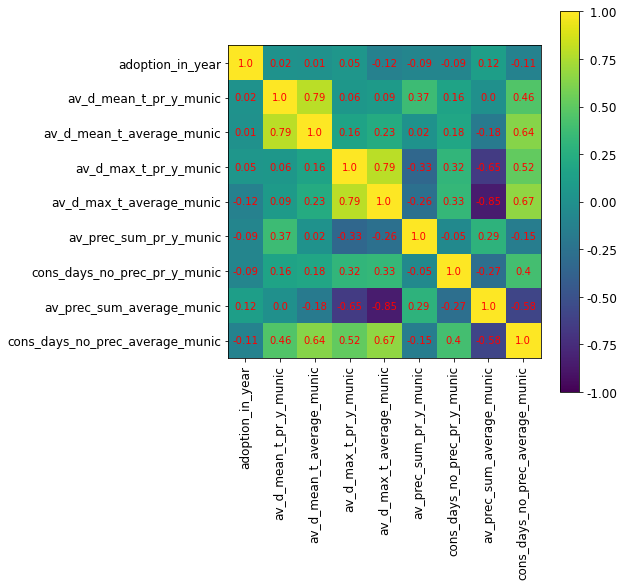

In [74]:
plot_correlation_heatmap(corr_matrix.loc[label + climate_features_kept, label + climate_features_kept], size=(7, 7))

In [75]:
sp_r_both.loc[climate_features_kept].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
av_prec_sum_average_munic,-0.176,0.118
av_d_max_t_pr_y_munic,0.304,0.045
av_d_mean_t_pr_y_munic,0.106,0.016
av_d_mean_t_average_munic,0.087,0.010
cons_days_no_prec_pr_y_munic,0.199,-0.090
av_prec_sum_pr_y_munic,-0.067,-0.091
cons_days_no_prec_average_munic,0.192,-0.112
av_d_max_t_average_munic,0.328,-0.119


In [76]:
class TransformClimateFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        climate_features = X.columns
        
        # All previous years ones excluded since the averages are more correlated!
        
        # Min temp: excluded all since high correlation with av_d_mean_t and
        # low with the target variable
        # Max temp: can keep only one of the two since perfectly correlated,
        # so exluded both days_max_t_over_30
        # Mean temp: excluded days_mean_t_over_20/25 since only one of these
        # kept and av_d_mean_t less correlated with max_t 
        # Prec: exclude both av_prec_sum_pr_y (too correlated with max_t) and
        # days_no
        
        # Definition of the ones to keep.
        feats_mean_t = [feat for feat in climate_features
                        if 'av_d_mean_t_average' in feat]
        feats_max_t = [feat for feat in climate_features
                        if 'av_d_max_t_average' in feat]
        feats_prec = [feat for feat in climate_features
                      if 'cons_days_no_prec_average' in feat]
        
        feats_to_keep = feats_mean_t + feats_max_t + feats_prec
        
        return X[feats_to_keep]

In [77]:
vif.loc[soil_features]

,VIF
features,
CaCO3_mean_munic,12.865
CN_mean_munic,12.671
N_mean_munic,3.708
P_mean_munic,6.674
pH_mean_munic,24.708


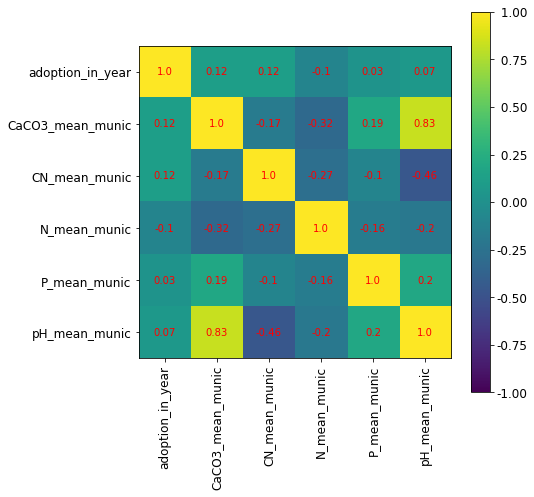

In [78]:
plot_correlation_heatmap(corr_matrix.loc[label + soil_features, label + soil_features], size=(7, 7))

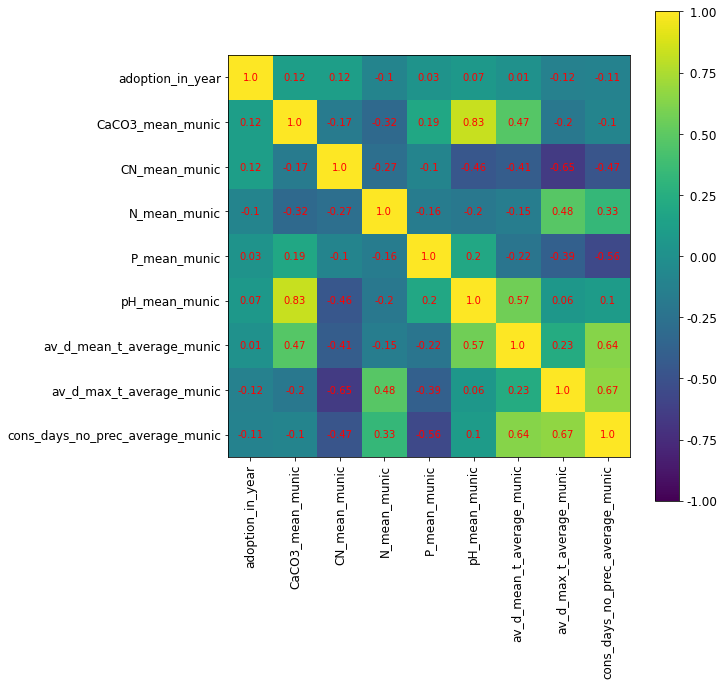

In [79]:
climate_features_kept_2 = ['av_d_mean_t_average_munic', 'av_d_max_t_average_munic', 'cons_days_no_prec_average_munic']
feats = label + soil_features + climate_features_kept_2
plot_correlation_heatmap(corr_matrix.loc[feats, feats], size=(9, 9))

In [80]:
spearman_results_both.loc[soil_features]

,spearman r only PCF,spearman r
CaCO3_mean_munic,-0.111,0.116
CN_mean_munic,-0.174,0.117
N_mean_munic,-0.009,-0.101
P_mean_munic,-0.055,0.033
pH_mean_munic,0.028,0.068


In [81]:
class TransformSoilFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        soil_features = X.columns

        # 'pH_mean_munic' excluded since high correlation with NC and CaCO3 (also with av_d_mean_t_average_munic)
        
        # Definition of the ones to keep. 
        feats_to_keep = [feat for feat in soil_features if feat != 'pH_mean_munic']

        return X[feats_to_keep]

### Economic features

In [82]:
class TransformEconomicFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # Nothing to do, it's just sbp_payments and we pass it
        return X

### Create of a dataset with these transformations

In [83]:
# Get features names
feat_lists = [census_features, adoption_features, climate_features, soil_features, economic_features]
transformers = [TransformCensusFeatures(), TransformAdoptionFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(),
               TransformEconomicFeatures()]

features_red = []
for f, t in zip(feat_lists, transformers):
    features = t.transform(dataset[f]).columns.to_list()
    features_red = features_red + features

In [84]:
len(features_red)

19

In [85]:
dataset.shape

(1241, 45)

In [86]:
from sklearn.compose import ColumnTransformer

full_dataset_transformation = ColumnTransformer([
    ('census', TransformCensusFeatures(), census_features),
    ('adoption', TransformAdoptionFeatures(), adoption_features),
    ('climate', TransformClimateFeatures(), climate_features),
    ('soil', TransformSoilFeatures(), soil_features),
    ('economic', TransformEconomicFeatures(), economic_features)
],
    remainder='drop')

In [87]:
dataset_attr_red = full_dataset_transformation.fit_transform(dataset)
dataset_attr_red = pd.DataFrame(dataset_attr_red, columns=features_red)
dataset_attr_red.insert(0, 'adoption_in_year', dataset[label].values)

### Reassess VIF

In [88]:
vif_attr_red = calculate_vif(dataset_attr_red)

In [89]:
vif_attr_red.sort_values('VIF', ascending=False)

,VIF
features,
Intercept,2962.432
cons_days_no_prec_average_munic,8.947
av_d_mean_t_average_munic,8.793
av_d_max_t_average_munic,8.024
tot_cumul_adoption_pr_y_port,6.814
work_unit_100ha,5.282
inc_mainly_ext,5.073
educ_none,4.402
educ_second_super,3.955


# Outliers

In [90]:
df = dataset_attr_red.copy()

In [91]:
normalized_df=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

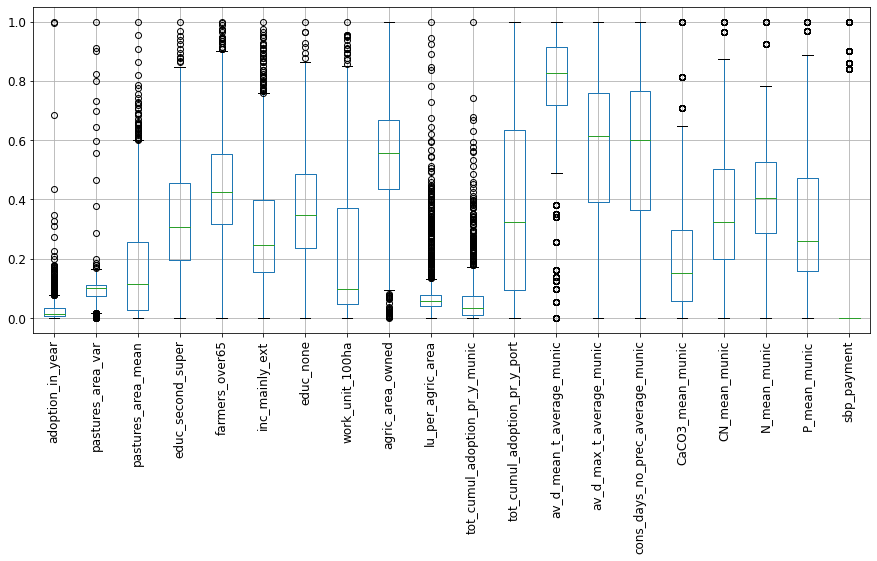

In [92]:
#mpl.rc('xtick', rotation=45, ha="right")
normalized_df.boxplot(figsize=(15, 6), rot=90)

## tot_cumul_adoption_pr_y_munic

<AxesSubplot:xlabel='tot_cumul_adoption_pr_y_munic', ylabel='adoption_in_year'>

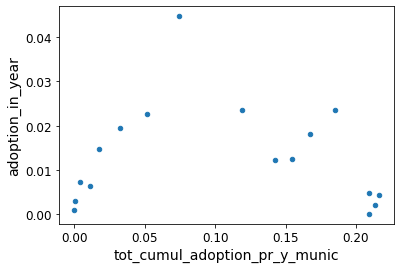

In [93]:
dataset_original.loc['Odemira'].plot(kind='scatter', x='tot_cumul_adoption_pr_y_munic', y='adoption_in_year')

### Remove outliers of adoption_in_year

{'whiskers': [<matplotlib.lines.Line2D at 0x1b3f62a94f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b3f62a9bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b3f62a9130>],
 'medians': [<matplotlib.lines.Line2D at 0x1b3f62b5280>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b3f62b55b0>],
 'means': []}

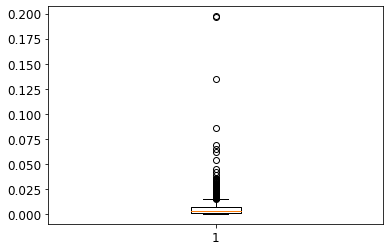

In [94]:
plt.boxplot(dataset['adoption_in_year'])

In [95]:
dataset_original.loc[dataset_original['adoption_in_year'] > 0.12]

adoption_in_year  tot_cumul_adoption_pr_y_munic  \
Municipality Year                                                    
Alcochete    2010             0.196                          0.195   
             2011             0.135                          0.391   
             2012             0.197                          0.526   

                   tot_cumul_adoption_pr_y_port  pastures_area_var  \
Municipality Year                                                    
Alcochete    2010                         0.054              1.000   
             2011                         0.063              1.007   
             2012                         0.068              1.013   

                   pastures_area_munic  pastures_area_mean  agric_area_mean  \
Municipality Year                                                             
Alcochete    2010                0.524              11.632           22.200   
             2011                0.532              11.911           23.170   
             2012                0.540              12.200           24.140   

                   agric_area_owned  tract_100ha  lu_cattle  ...  \
Municipality Year                                            ...   
Alcochete    2010             0.768        4.300      0.332  ...   
             2011             0.748        4.390      0.319  ...   
             2012             0.728        4.480      0.308  ...   

                   days_min_t_under_0_average_munic  \
Municipality Year                                     
Alcochete    2010                             0.083   
             2011                             0.083   
             2012                             0.083   

                   av_prec_sum_average_munic  days_no_prec_average_munic  \
Municipality Year                                                          
Alcochete    2010                    736.121                     282.125   
             2011                    736.121                     282.125   
             2012                    736.121                     282.125   

                   cons_days_no_prec_average_munic  CaCO3_mean_munic  \
Municipality Year                                                      
Alcochete    2010                           57.646            52.474   
             2011                           57.646            52.474   
             2012                           57.646            52.474   

                   CN_mean_munic  N_mean_munic  P_mean_munic  pH_mean_munic  \
Municipality Year                                                             
Alcochete    2010         11.856         1.057        17.545          6.464   
             2011         11.856         1.057        17.545          6.464   
             2012         11.856         1.057        17.545          6.464   

                   sbp_payment  
Municipality Year               
Alcochete    2010      132.100  
             2011      128.790  
             2012      137.960  

[3 rows x 45 columns]

In [96]:
dataset_red = dataset_original.drop(
    dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
)
print(len(dataset), len(dataset_red))

1241 1238


### Reassessment of outlies in adoption features after first removal

In [97]:
df = dataset_red[['adoption_in_year', 'tot_cumul_adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_port']]
norm_df_red=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

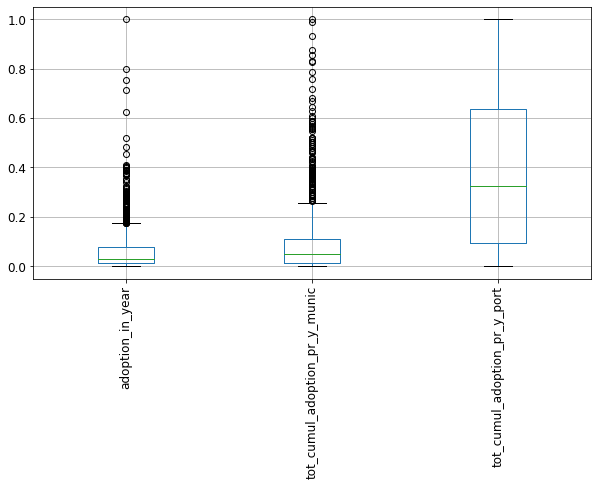

In [98]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red.boxplot(figsize=(10, 5), rot=90)

## Metrics for final set of features

In [101]:
d = pd.DataFrame(index=features_red)

In [102]:
d['VIF'] = vif_attr_red

In [103]:
dataset_attr_red_PCF = pd.DataFrame(dataset_attr_red.values, index=dataset_original.index,
                                    columns=dataset_attr_red.columns).loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [104]:
d2 = get_spearman_both(features_red, dataset_attr_red, dataset_attr_red_PCF)

In [105]:
d3 = pd.concat([d2, d], axis=1)

In [106]:
d3

,spearman r only PCF,spearman r,VIF
pastures_area_var,0.039,0.199,1.332
pastures_area_mean,0.313,0.018,2.575
educ_second_super,0.402,0.107,3.955
farmers_over65,-0.187,0.011,3.650
inc_mainly_ext,-0.325,0.024,5.073
educ_none,-0.120,-0.163,4.402
work_unit_100ha,-0.251,0.052,5.282
agric_area_owned,-0.131,0.003,2.142
lu_per_agric_area,-0.069,0.097,1.755
tot_cumul_adoption_pr_y_munic,0.076,0.456,1.721


In [107]:
corr_matrix_final = dataset_attr_red.corr(method='spearman').round(decimals=2)